In [3]:
from transformers import AutoModel, AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
import pandas as pd
from datasets import load_dataset, DatasetDict, load_dataset
from transformers.integrations import TensorBoardCallback
from torch.utils.tensorboard import SummaryWriter

/Users/devakrishna/opt/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [6]:
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
bert = AutoModel.from_pretrained('ai4bharat/indic-bert')

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
model = AutoModelForSequenceClassification.from_pretrained('ai4bharat/indic-bert', num_labels=2)

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

In [5]:
test = pd.read_csv("./dataset/validation.csv")

In [11]:
dataset = load_dataset('csv', data_files={'test': './dataset/test.csv'})

Using custom data configuration default-69f1efac6aa08f44
Reusing dataset csv (/Users/devakrishna/.cache/huggingface/datasets/csv/default-69f1efac6aa08f44/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=100)

In [43]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [44]:
full_eval_dataset = tokenized_datasets["test"]

In [46]:
from transformers import TrainingArguments

training_args = TrainingArguments("logging_steps")
training_args.logging_steps = 5
training_args.num_train_epochs = 10

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [59]:
trainer = Trainer(
    model=model,\
    args=training_args,\
    train_dataset=full_train_dataset,\
    eval_dataset=full_eval_dataset,\
    callbacks=[MyCallback(writer)]
)

In [58]:
model_name = "hugginface_fin_tune"
writer = SummaryWriter(f'runs/{model_name}')

In [60]:
class MyCallback(TensorBoardCallback):
    pass

In [ ]:
trainer.train()

In [9]:
model = AutoModelForSequenceClassification.from_pretrained('./indic_bert_model/logging_steps/checkpoint-19000/', num_labels=2,output_attentions=True)

In [15]:
import torch

In [16]:
import numpy as np

In [45]:
len(full_eval_dataset["text"])

654

In [59]:
from tqdm import tqdm

In [60]:
count = 0
preds = []
for text in tqdm(full_eval_dataset["text"]):
    input_ = tokenizer(text, return_tensors="pt")
    preds.append(torch.argmax(model(**input_).logits).numpy())

100%|██████████| 654/654 [01:30<00:00,  7.24it/s]


In [61]:
preds_ = []
for pred in preds:
    preds_.append(pred.tolist())

In [62]:
labels = []
for label in full_eval_dataset["label"]:
    labels.append(label)

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [63]:
accuracy_score(labels, preds_)

0.7981651376146789

In [64]:
f1_score(labels, preds_, average="weighted")

0.8041307295845399

In [51]:
confusion_matrix(labels, preds_)

array([[480,  56],
       [ 70,  48]])

In [27]:
from bertviz import head_view, model_view

In [2]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None, layer=None, heads=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start, layer=layer, heads=heads)

In [1]:
# sentence_a = "தைரியமா இந்த மாதிரி ஒரு கதைய எடுத்த துக்கு இது பல சில இயக்குனர்களுக்கும் ஜாதி ஓட்டு வங்கர்துகு சில அரசியல்வாதி நாய்களுக்கும் ஒரு செருப்படியா இருக்கும் படம் வெற்றிபெற வாழ்த்துக்கள்"
# show_head_view(model, tokenizer, sentence_a)

In [117]:
inputs = tokenizer.encode(sentence_a, return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

In [23]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
import torch

In [20]:
model_ = BertModel.from_pretrained('./indic_bert_model/logging_steps/checkpoint-19000/')

In [21]:
tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
bert = AutoModel.from_pretrained('ai4bharat/indic-bert')

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'sop_classifier.classifier.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
input_ = tokenizer(sentence_a, return_tensors="pt")
torch.argmax(model(**input_).logits).numpy()

array(1)

In [25]:
sentence_a = "தைரியமா இந்த மாதிரி ஒரு கதைய எடுத்த துக்கு இது பல சில இயக்குனர்களுக்கும் ஜாதி ஓட்டு வங்கர்துகு சில அரசியல்வாதி நாய்களுக்கும் ஒரு செருப்படியா இருக்கும் படம் வெற்றிபெற வாழ்த்துக்கள்"

In [26]:
show(model_, "bert", tokenizer, sentence_a, layer=2, head=0, display_mode="light")

NameError: name 'show' is not defined

In [2]:
# show_head_view(model, tokenizer, sentence_a)

In [3]:
# inputs = tokenizer.encode(sentence_a, return_tensors='pt')
# outputs = model(inputs)
# attention = outputs[-1]  # Output includes attention weights when output_attentions=True
# tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
# model_view(attention, tokens, display_mode="light")

In [153]:
from tensorboard.backend.event_processing import event_accumulator

In [156]:
ea = event_accumulator.EventAccumulator('./runs/hugginface_fin_tune/events.out.tfevents.1638911304.ip-172-31-29-140.30684.0')

In [167]:
import matplotlib.pyplot as plt

In [170]:
values = []
for value in ea.Scalars('train/loss'):
    values.append(value.value)

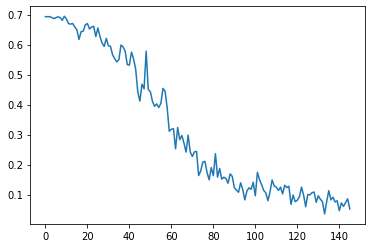

In [173]:
plt.plot(values)